# Move to the directory

In [0]:
%cd ./drive/My\ Drive/perso/Emotion_recognition_over_txt

/content/drive/My Drive/perso/Emotion_recognition_over_txt


# Import all the library

In [0]:
import torch
import torch.nn as nn
from torchtext import data
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import numpy as np
import csv

import random

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import itertools

%matplotlib inline

# Fetch and visualize data

convert data in CSV file

In [0]:
with open('emotion.csv', 'w') as f1:
    writer = csv.writer(f1)
    writer.writerow(["id", "x", "y"]) #headers
    with open("./emotion.data", "r", newline='') as f2:
      for s in f2:
        sentence = s.split(",")
        writer.writerow([sentence[0], sentence[1], sentence[2]])

In [0]:
X_prepocessing = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
Y_prepocessing = data.LabelField(dtype = torch.float,batch_first=True)

fields = [(None, None), ('x',X_prepocessing),('y', Y_prepocessing)]

#loading custom dataset
all_data = data.TabularDataset(path = 'emotion.csv',format = 'csv',fields = fields,skip_header = True)
all_data.examples = all_data.examples[1::]

In [0]:
#print preprocessed text
train_data, test_data, val_data = all_data.split(split_ratio=[0.90, 0.02, 0.08], random_state = random.seed(31))

In [0]:
print("Training set size {}".format(len(train_data)))
print("Test set size {}".format(len(test_data)))
print("Validation set size {}".format(len(val_data)))

Training set size 375128
Test set size 33345
Validation set size 8336


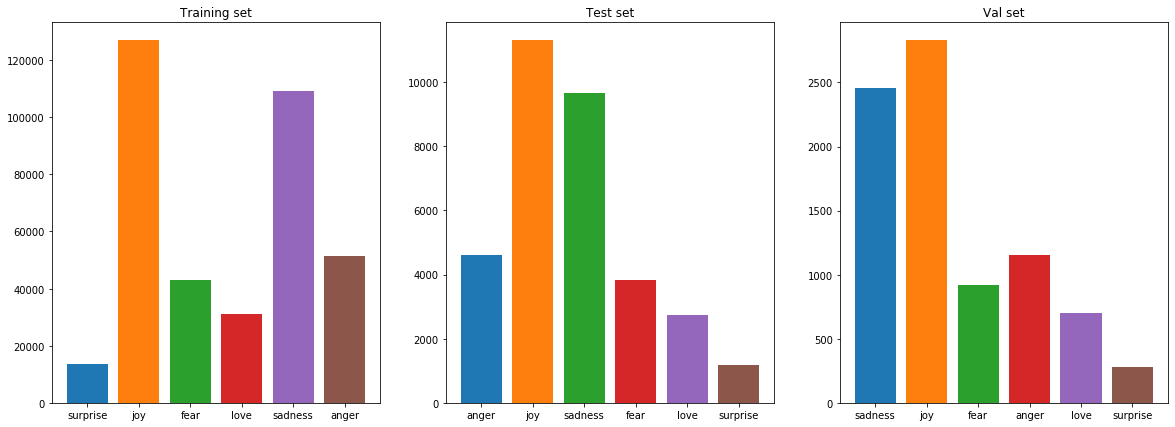

In [235]:
train_data_spread = {}
for data in train_data : 
  if data.y in train_data_spread:
    train_data_spread[data.y] += 1
  else:
    train_data_spread[data.y] = 1

test_data_spread = {}
for data in test_data : 
  if data.y in test_data_spread:
    test_data_spread[data.y] += 1
  else:
    test_data_spread[data.y] = 1

val_data_spread = {}
for data in val_data : 
  if data.y in val_data_spread:
    val_data_spread[data.y] += 1
  else:
    val_data_spread[data.y] = 1


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
axes[0].set_title('Training set')
for item in train_data_spread.keys():
  axes[0].bar(item, train_data_spread[item])
axes[1].set_title('Test set')
for item in test_data_spread.keys():
  axes[1].bar(item, test_data_spread[item])
axes[2].set_title('Val set')
for item in val_data_spread.keys():
  axes[2].bar(item, val_data_spread[item])


We can see that our dataset is not balanced at all.

Build the vocabulary

In [0]:
#initialize glove embeddings
X_prepocessing.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d") # using pretrained embedding
Y_prepocessing.build_vocab(train_data)
#No. of unique tokens in text
print("Size of X_prepocessing vocabulary:",len(X_prepocessing.vocab))
#No. of unique tokens in label
print("Size of Y_prepocessing vocabulary:",len(Y_prepocessing.vocab))
#Commonly used words
print(X_prepocessing.vocab.freqs.most_common(10))  
#Word dictionary
print(X_prepocessing.vocab.stoi)   #string to identifier

.vector_cache/glove.6B.zip: 862MB [06:25, 2.23MB/s]                          
100%|█████████▉| 399295/400000 [00:19<00:00, 22465.52it/s]

Size of X_prepocessing vocabulary: 28992
Size of Y_prepocessing vocabulary: 6
[('i', 680826), ('feel', 260905), ('and', 224884), ('to', 209747), ('the', 194763), ('a', 146389), ('feeling', 120835), ('that', 119902), ('of', 116795), ('my', 99969)]
defaultdict(<function _default_unk_index at 0x7f4c812dd9d8>, {'<unk>': 0, '<pad>': 1, 'i': 2, 'feel': 3, 'and': 4, 'to': 5, 'the': 6, 'a': 7, 'feeling': 8, 'that': 9, 'of': 10, 'my': 11, 'in': 12, 'it': 13, 'm': 14, 'like': 15, 'so': 16, 'for': 17, 'have': 18, 'me': 19, 'was': 20, 'but': 21, 'is': 22, 'this': 23, 'am': 24, 'with': 25, 'not': 26, 'be': 27, 'about': 28, 'nt': 29, 'you': 30, 'as': 31, 'on': 32, 'do': 33, 'just': 34, 'when': 35, 'at': 36, 'or': 37, 'all': 38, 'because': 39, 'more': 40, 'can': 41, 'really': 42, 'up': 43, 't': 44, 'know': 45, 'are': 46, 'by': 47, 'been': 48, 'very': 49, 'what': 50, 'out': 51, 'myself': 52, 'if': 53, 'time': 54, 's': 55, 'how': 56, 'get': 57, 'would': 58, 'they': 59, 've': 60, 'had': 61, 'little': 62

In [0]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print("Using {}".format(device))

Using cuda


In [0]:
#set batch size
BATCH_SIZE = 64

#Load an iterator for train, test, val
train_iterator = data.BucketIterator(
    train_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda item: len(item.x),
    sort_within_batch=True,
    device = device)

test_iterator = data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda item: len(item.x),
    sort_within_batch=True,
    device = device)

val_iterator = data.BucketIterator(
    val_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda item: len(item.x),
    sort_within_batch=True,
    device = device)

# Defining model

In [0]:
class Net(nn.Module):
  def __init__(self, vocab_size, emb_dim, hidden_state, nb_layers, nb_class, padding_idx, bidirectional=True):
    super(Net, self).__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)

    self.lstm = nn.LSTM(emb_dim, hidden_state, nb_layers, batch_first=True, bidirectional=True)
    
    self.fc1 = nn.Linear(hidden_state * 2, nb_class)
    
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.emb(x)

    output, (h_n, c_n) = self.lstm(x)

    h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim = 1)
    
    x = self.fc1(h_n)

    return self.softmax(x) #output ==> (BS, max_nb_word, nb_class)

# Train model

In [0]:
MODELS_DIR = "models"
MODEL_NAME = "best_model.pth"
def save_model(model, directory=MODELS_DIR, model_name=MODEL_NAME):
  if not os.path.exists(directory):
      os.makedirs(directory)
  if ".pth" not in model_name:
    model_name += ".pth"
  print("Saving model")
  torch.save(model.state_dict(), os.path.join(directory, model_name))

In [0]:
#GLOBAL PARAM
LOSS = 'loss'
EVAL_PRECISION = 'eval_precision'

#Training parameters
num_epochs = 50
early_stopping_rate = 5
patience = early_stopping_rate
early_stopping_param = LOSS # loss || eval_precision
lr_decay_patience = 2
assert early_stopping_param == LOSS or early_stopping_param == EVAL_PRECISION, "early stopping parameter is not correct, you have to chose it between loss or eval_precision"

#Neural net parameters
vocab_size = len(X_prepocessing.vocab)
nb_class = len(Y_prepocessing.vocab)
emb_dim = 200
hidden_state = 320
nb_layers = 1
bidirectional = True
padding_idx = X_prepocessing.vocab.stoi['<pad>'] #get the index of padding in the vocabulary

model = Net(vocab_size, emb_dim, hidden_state, nb_layers, nb_class, padding_idx,bidirectional).to(device)
print(model)

Net(
  (emb): Embedding(28992, 200, padding_idx=1)
  (lstm): LSTM(200, 320, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=640, out_features=6, bias=True)
  (softmax): Softmax(dim=-1)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#learning rate optimizer ==> https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min' if early_stopping_param == LOSS else 'max', patience=lr_decay_patience, verbose=True) 

best_early_stopping_param = 0 if early_stopping_param == EVAL_PRECISION else float("inf")

print("Start training :")
for epoch in range(50):
  model.train()
  epoch_loss = 0
  batch_loss = 0
  print("Starting epoch", epoch+1)
  for i, ((data, labels), _) in enumerate(train_iterator):
    X = data[0].to(device)
    y = labels.to(device)
    txt_lengths = data[1].to(device)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    preds = model(X).float()
    loss = criterion(preds, y.long())
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    batch_loss = round(loss.item(), 2)

    if i % 1000 == 0: #every 1000 batch
      print("loss of the {}'th batch : {}".format(i, batch_loss))
  epoch_loss = round(epoch_loss, 2)
  print("Epoch {}'th loss: {}".format(epoch+1, epoch_loss))
  print()
  print("Evaluation ...")
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    precision = 0
    for (data, labels), _ in train_iterator:
      X = X.to(device)
      y = y.to(device)
      
      outputs = model(X).float()
      _, predicted = torch.max(outputs.data, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()

    precision = round((100 * correct / total), 2)
    print('Precision on the validation set: {}'.format(precision))
  print()
  #early_stopping
  if early_stopping_param == LOSS:
    if epoch_loss < best_early_stopping_param:
      best_early_stopping_param = epoch_loss
      patience = early_stopping_rate
      save_model(model)
    else:
      patience -= 1
  elif early_stopping_param == EVAL_PRECISION:
    if precision > best_early_stopping_param:
      best_early_stopping_aram = precision
      patience = early_stopping_rate
      save_model(model)
    else:
      patience -= 1
  

  print("Early stopping patience : {}".format(patience))

  if patience == 0:
    print("Training stopped due to early stopping.")
    break

  # Note that step should be called after validate()
  scheduler.step(best_early_stopping_param)
  print()


Start training :
Starting epoch 1
loss of the 0'th batch : 1.61
loss of the 1000'th batch : 1.53
loss of the 2000'th batch : 1.44
loss of the 3000'th batch : 1.46
loss of the 4000'th batch : 1.53
loss of the 5000'th batch : 1.67
Epoch 1'th loss: 9257.07

Evaluation ...
Precision on the validation set: 39.06

Saving model
Early stopping patience : 5

Starting epoch 2
loss of the 0'th batch : 1.63
loss of the 1000'th batch : 1.65
loss of the 2000'th batch : 1.57
loss of the 3000'th batch : 1.37
loss of the 4000'th batch : 1.39
loss of the 5000'th batch : 1.45
Epoch 2'th loss: 8699.07

Evaluation ...
Precision on the validation set: 62.5

Saving model
Early stopping patience : 5

Starting epoch 3
loss of the 0'th batch : 1.39
loss of the 1000'th batch : 1.4
loss of the 2000'th batch : 1.51
loss of the 3000'th batch : 1.46
loss of the 4000'th batch : 1.46
loss of the 5000'th batch : 1.37
Epoch 3'th loss: 8410.35

Evaluation ...
Precision on the validation set: 59.38

Saving model
Early sto

# Test model

In [38]:
model = Net(vocab_size, emb_dim, hidden_state, nb_layers, nb_class, padding_idx,bidirectional).to(device)
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, MODEL_NAME)))

<All keys matched successfully>

In [62]:
all_preds = torch.tensor([], dtype=torch.long).to(device) #used for ploting results
all_gt = torch.tensor([], dtype=torch.long).to(device) #used for plotting results
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for (data, labels), _ in test_iterator:
      X = X.to(device)
      y = y.to(device).long()
      _, predicted = torch.max(outputs.data, 1)
      predicted = predicted.long()
      all_preds = torch.cat(
              (all_preds, predicted)
              ,dim=0
          )
      all_gt = torch.cat(
              (all_gt, y)
              ,dim=0
          )
      total += y.size(0)
      correct += (predicted == y).sum().item()
    
precision = round((100 * correct / total), 2)
print('Precision on the test set: {}'.format(precision))

Precision on the test set: 95.31


In [0]:
#this code is taken from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

tensor([3, 0, 0,  ..., 1, 1, 3], device='cuda:0')


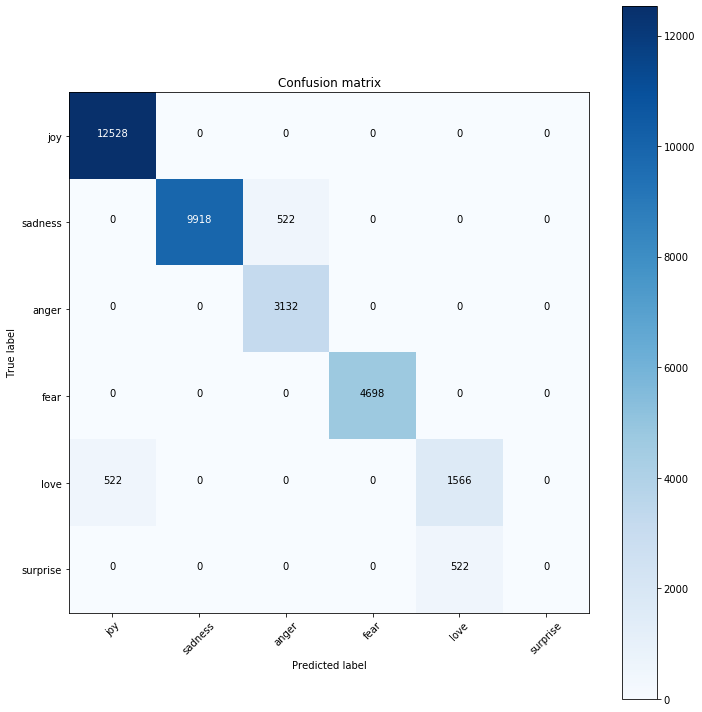

In [216]:
cm = confusion_matrix(all_gt.cpu(), all_preds.cpu())
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, Y_prepocessing.vocab.itos)

We don't have enough of surprised data to make our model understand this sentiment. and we can clearly see that whanever our model is not predicting well, it's when the two emotions are correlated

In [0]:
def get_emotion(model, sentence):
  """
  function that return the emotion of the sentence given in the parameter by the order of the weights
  Args:
    - model : model to use to predict
    - sentence : sentence to predict its emotion
  return:
    - list of the emotion ordered by their weights
    - list of the weights
  """
  X = torch.Tensor([[X_prepocessing.vocab.stoi[word] for word in sentence.split(" ")]]).to(device).long()
  preds = model(X)
  result = torch.argmax(preds, dim=-1)
  return [Y_prepocessing.vocab.itos[p.item()] for p in preds[0].argsort(dim=-1, descending=True)], preds

In [237]:
print(get_emotion(model, "i was happy but now i am furious"))

(['anger', 'love', 'joy', 'surprise', 'fear', 'sadness'], tensor([[3.9040e-03, 1.3445e-06, 9.8639e-01, 1.5221e-06, 9.6409e-03, 6.1463e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward>))
